In [1]:
import csv
import gensim.models.keyedvectors as kv
import numpy as np
import bz2
import os
import matplotlib.pyplot as plt

In [2]:
rows=list()
# open Harvard Inquirer
with open('../lexicons/Harvard_Inquirer-inqtabs.txt', 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for i,row in enumerate(reader):
        if i == 0:
            header = row
        else:
            rows.append(row)
            
inquirer = dict()

for c in header:
   
    # extract index from header
    idx = header.index(c)
   
    # extract words and drop to lowercase
    inquirer[c] = [w[0].lower() for w in rows if w[idx] != '']
   
    # remove alternate meanings and reduce duplicates
    inquirer[c] = list(set([w.split("#")[0] for w in inquirer[c]]))

In [3]:
genre_models=dict()
input_data = ["../models/drama-17412-reduced.w2v.bz2",
             "../models/poetry-56817-reduced.w2v.bz2",
             "../models/fiction-54886-reduced.w2v.bz2"]

for f in input_data:
    model_name = os.path.basename(f).split(".")[0]
    print("starting: {0}".format(model_name))
    model = kv.KeyedVectors.load_word2vec_format(bz2.open(f))
    genre_models[model_name] = model

starting: drama-17412-reduced
starting: poetry-56817-reduced
starting: fiction-54886-reduced


In [4]:
feelings = ["Pleasur","Pain","Feel","Arousal", "EMOT", "Virtue", "Vice"]
valence = ["Positiv", "Negativ"]
institutional = ["Polit@", "Relig", "Legal", "Milit", "Exprsv", "Econ@", "Academ"]

w2c = dict()
for c in feelings + valence + institutional:
    for w in inquirer[c]:
        if w not in w2c:
            tmp=list()
            tmp.append(c)
            w2c[w] = tmp
        else:
            w2c[w].append(c)

In [5]:
def neighbors_by_category(model,word,k=100):
    neighbors=list()
    for wvp in genre_models[model].most_similar(word,topn=k):
        if wvp[0] in w2c:
            neighbors.append([wvp[0],w2c[wvp[0]],wvp[1]])
        else:
            neighbors.append([wvp[0],["None"],wvp[1]])
    return neighbors

In [6]:
def plot_neighbor_categories(model,word,k=100):
    data = neighbors_by_category(model,word,k=k)
    value_dict=dict()
    for i in [x[1] for x in data]:
        for j in i:
            if j not in value_dict:
                value_dict[j] = 1
            else:
                value_dict[j] += 1
    labels=list()
    colors=list()
    values=list()

    for i in sorted(value_dict.items(), key=lambda x: x[1], reverse=True):
        labels.append(i[0])
        values.append(i[1])
        if word in w2c:
            if i[0] in w2c[word]:
                colors.append("tomato")
            else:
                colors.append("slateblue")
        else:
            # no categories for query term?
            colors.append("slateblue")
    plt.barh(np.arange(len(value_dict)),values,color=colors,tick_label=labels)
    plt.title("Neighbors by Harvard Inquirer Categories: {0}".format(word))
    plt.xlabel("Neighbor Category Counts (Total, k={0})\n model: {1}".format(k,model))
    plt.show()

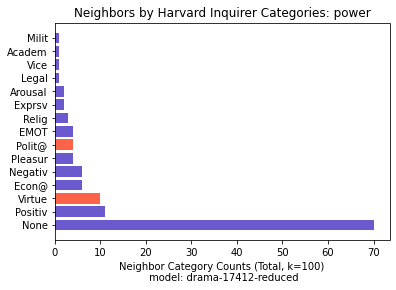

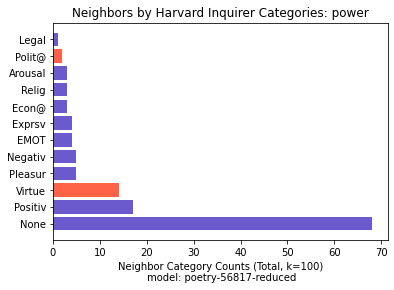

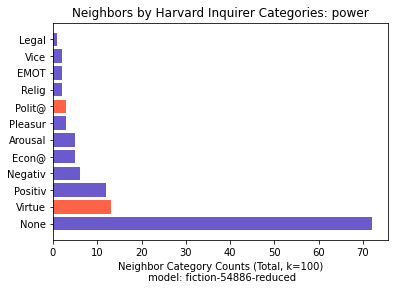

In [7]:
for model in genre_models.keys():
    plot_neighbor_categories(model,"power")